In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install --upgrade matplotlib
!pip install basemap
!pip install scikit-learn
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/database.csv")
data.columns
data = data[['Date', 'Time', 'Latitude', 'Longitude', 'Depth', 'Magnitude']]
data.head()

,Date,Time,Latitude,Longitude,Depth,Magnitude
0,01/02/1965,13:44:18,19.246,145.616,131.6,6.0
1,01/04/1965,11:29:49,1.863,127.352,80.0,5.8
2,01/05/1965,18:05:58,-20.579,-173.972,20.0,6.2
3,01/08/1965,18:49:43,-59.076,-23.557,15.0,5.8
4,01/09/1965,13:32:50,11.938,126.427,15.0,5.8


In [ ]:
import datetime
import time

timestamp = []
for d, t in zip(data['Date'], data['Time']):
    try:
        ts = datetime.datetime.strptime(d+' '+t, '%m/%d/%Y %H:%M:%S')
        timestamp.append(time.mktime(ts.timetuple()))
    except ValueError:
        # print('ValueError')
        timestamp.append('ValueError')
timeStamp = pd.Series(timestamp)
data['Timestamp'] = timeStamp.values
final_data = data.drop(['Date', 'Time'], axis=1)
final_data = final_data[final_data.Timestamp != 'ValueError']
final_data.head()

,Latitude,Longitude,Depth,Magnitude,Timestamp
0,19.246,145.616,131.6,6.0,-157630542.0
1,1.863,127.352,80.0,5.8,-157465811.0
2,-20.579,-173.972,20.0,6.2,-157355642.0
3,-59.076,-23.557,15.0,5.8,-157093817.0
4,11.938,126.427,15.0,5.8,-157026430.0


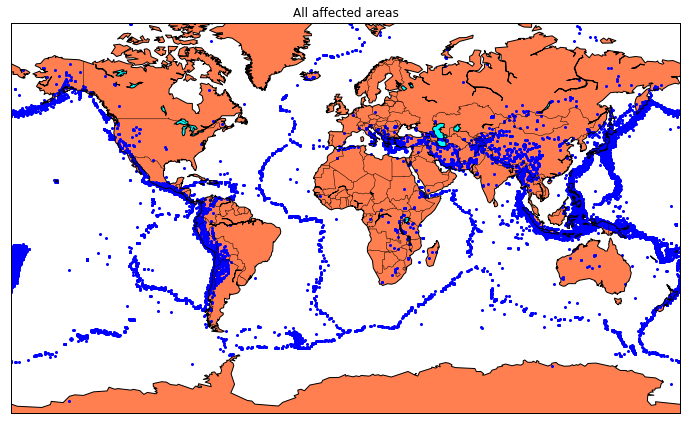

In [ ]:
import mpl_toolkits
from mpl_toolkits.basemap import Basemap

m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=80, llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')

longitudes = data["Longitude"].tolist()
latitudes = data["Latitude"].tolist()
#m = Basemap(width=12000000,height=9000000,projection='lcc',
            #resolution=None,lat_1=80.,lat_2=55,lat_0=80,lon_0=-107.)
x,y = m(longitudes,latitudes)

fig = plt.figure(figsize=(12,10))
plt.title("All affected areas")
m.plot(x, y, "o", markersize = 2, color = 'blue')
m.drawcoastlines()
m.fillcontinents(color='coral',lake_color='aqua')
m.drawmapboundary()
m.drawcountries()
plt.show()

In [ ]:
X = final_data[['Timestamp', 'Latitude', 'Longitude']]
y = final_data[['Magnitude', 'Depth']]
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(18727, 3) (4682, 3) (18727, 2) (4682, 2)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense

def create_model(neurons, activation, optimizer, loss):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(3,)))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=create_model, verbose=0)

neurons = [16, 64, 128, 256]
# neurons = [16]
batch_size = [10, 20, 50, 100]
# batch_size = [10]
epochs = [10]
activation = ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear', 'exponential']
# activation = ['sigmoid', 'relu']
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# optimizer = ['SGD', 'Adadelta']
loss = ['squared_hinge']

param_grid = dict(neurons=neurons, batch_size=batch_size, epochs=epochs, activation=activation, optimizer=optimizer, loss=loss)

<ipython-input-30-7cd834fd14f2>:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


In [ ]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(3,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='SGD', loss='squared_hinge', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=10, epochs=20, verbose=1, validation_data=(X_test, y_test))

[test_loss, test_acc] = model.evaluate(X_test, y_test)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

Epoch 1/20
1873/1873 [==============================] - 10s 5ms/step - loss: 0.5000 - accuracy: 0.0189 - val_loss: 0.5000 - val_accuracy: 0.0186
Epoch 2/20
1207/1873 [==================>...........] - ETA: 2s - loss: 0.5000 - accuracy: 0.0181

KeyboardInterrupt: ignored